In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
tfd = tfp.distributions
tfb = tfp.bijectors
vi = tfp.vi

import matplotlib.pyplot as plt
from bakeoff.TensorFlow_Prob.run_tfp import make_conditioned_lp

In [10]:
mu_prior, sigma_prior = 0, 10
sigma_like = 1.0
max_iters = 100_000
target_log_prob_fn = make_conditioned_lp(
  prior_dist = tfd.Normal(mu_prior, sigma_prior),
  likelihood_dist = lambda z: tfd.Normal(z, sigma_like),
  x = np.array([])
)
q_loc = tf.Variable(0.0, name=f'q_loc', dtype=np.float32)
q_scale = tf.Variable(10.0, name=f'q_scale', dtype=np.float32)
surrogate_posterior = tfd.Normal(loc=q_loc, scale=q_scale)

q_loc_2 = tf.Variable(0.0, name=f'q_loc_2', dtype=np.float32)
q_scale_2 = tf.Variable(10.0, name=f'q_scale_2', dtype=np.float32)
surrogate_posterior_2 = tfd.Normal(loc=q_loc_2, scale=q_scale_2)


q_z_single = tfp.experimental.util.make_trainable(tfd.Normal, name='q_z')
q_z_multiple = tfp.experimental.util.make_trainable(tfd.Normal, name='q_z')

def trace_fn_single(traceable_quantities):
    return q_z_single.mean(), q_z_single.stddev(), traceable_quantities.loss

def trace_fn_multiple(traceable_quantities):
    return q_z_multiple.mean(), q_z_multiple.stddev(), traceable_quantities.loss

single_sample_losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    #seed=SEED,
    surrogate_posterior=q_z_single,
    trainable_variables=q_z_single.trainable_variables,
    # the second parameter is the value before the softplus transformation
    optimizer=tf.optimizers.Adagrad(learning_rate=0.1),
    trace_fn= trace_fn_single,
    num_steps=max_iters)
multi_sample_losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    #seed=SEED,
    surrogate_posterior=q_z_multiple,
    trainable_variables=q_z_multiple.trainable_variables,
    # the second parameter is the value before the softplus transformation
    optimizer=tf.optimizers.Adagrad(learning_rate=0.1),
    trace_fn= trace_fn_multiple,
    num_steps=max_iters,
    sample_size=100)


In [11]:
single_sample_losses

(<tf.Tensor: shape=(100000,), dtype=float32, numpy=
 array([ 0.25132534,  0.2481724 ,  0.24476746, ..., -0.03361854,
        -0.03434938, -0.03439876], shape=(100000,), dtype=float32)>,
 <tf.Tensor: shape=(100000,), dtype=float32, numpy=
 array([ 0.64269906,  0.6749505 ,  0.7023053 , ..., 10.009145  ,
        10.008251  , 10.00847   ], shape=(100000,), dtype=float32)>,
 <tf.Tensor: shape=(100000,), dtype=float32, numpy=
 array([ 2.7016683e+00,  2.0753450e+00,  1.9456222e+00, ...,
         6.3691139e-03, -3.8595200e-03, -1.3289452e-03],
       shape=(100000,), dtype=float32)>)

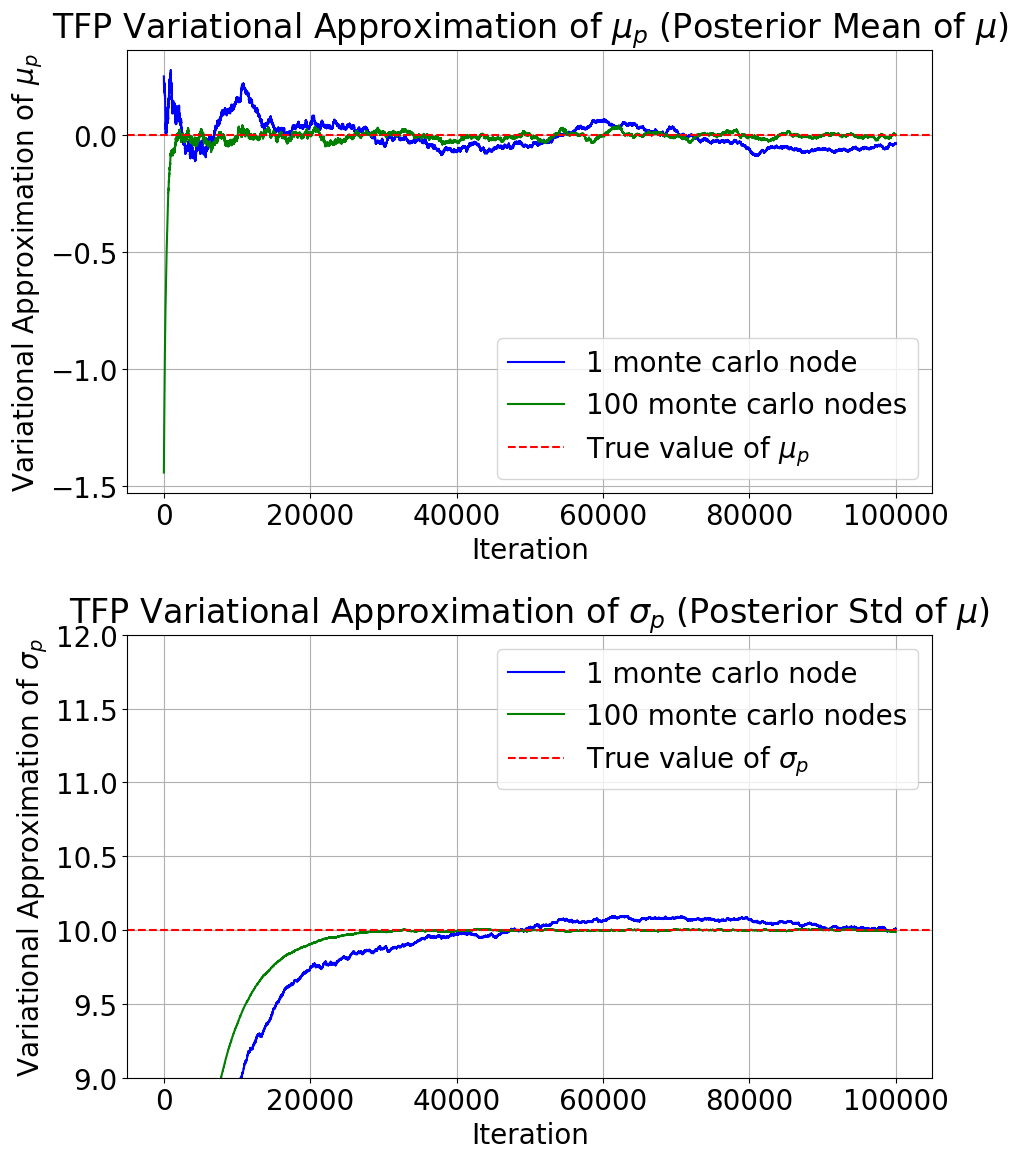

In [12]:
# plot single_tracker vs multi_tracker for the mean and std of mu
# add dashed lines for true values of mu mean and std which is N(0, 1)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# set font size to 14
plt.rcParams.update({'font.size': 20})

axs[0].plot(single_sample_losses[0], label='1 monte carlo node', color='blue')
axs[0].plot(multi_sample_losses[0], label='100 monte carlo nodes', color='green')
axs[0].axhline(mu_prior, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[0].set_title(r'TFP Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[0].legend()
axs[0].grid()

axs[1].plot(single_sample_losses[1], label='1 monte carlo node', color='blue')
axs[1].plot(multi_sample_losses[1], label='100 monte carlo nodes', color='green')
axs[1].axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[1].set_title(r'TFP Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[1].set_xlabel('Iteration', fontsize=20)
axs[1].set_ylabel(r'Variational Approximation of $\sigma_p$')
axs[1].legend()
axs[1].grid()
axs[1].set_ylim(sigma_prior - 1, sigma_prior + 2)

plt.tight_layout()
plt.show()